<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-imports-and-dfs" data-toc-modified-id="Load-imports-and-dfs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load imports and dfs</a></span></li><li><span><a href="#Blend" data-toc-modified-id="Blend-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Blend</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


1. Load imports & test, train DFs
2. Apply stratified kfold & traing with lgbm and submit to kaggle
3. Check for missing data feature engineering parts missed if score > 3.7
4. Split the training set to train & validation
5. Train over RF to get a benchmark of the dataset
6. Drop irrelevant features by sorting on feature importance
7. Drop redundant features by plotting a Dendogram and removing the redundancy
8. Use a feature interpreter to see which feature is contributing lot to prediction
9. Use extrapolation to see if we can remove feature which add bias of training & validation set
10. Use partial dependence plot to see outliers/missed features
11. Submit to kaggle the RF model and see the score
11. Use stratified kfold to train the RF model and submit to kaggle
12. Repeat again with LGBM/XGBoost/Adaboost. Stack the model and submit to kaggle


### Load imports and dfs

In [2]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import warnings

In [3]:
train_df2 = feather.read_dataframe('train_df_beta')
test_df2 = feather.read_dataframe('test_df_beta')

In [4]:
for df in [train_df2, test_df2]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [72]:
del_cols = ['first_active_monthIs_month_start', 'authorized_flag_1_mean', 'first_active_monthIs_year_start',
       'first_active_monthIs_year_end', 'first_active_monthIs_quarter_end', 'avg_trans_per_merchant',
       'first_active_monthIs_month_end', 'first_active_monthDay', 'card_id_size',
       'authorized_flag_1_amount_mean_mean', 'authorized_flag_1_amount_sum_sum','card_id', 'first_active_month','target','outliers']

In [73]:
def one_hot_encode_fe(df):
    return pd.get_dummies(df, columns=['feature_1', 'feature_2', 'feature_3'])

In [74]:
# [train_df2, test_df2] = [one_hot_encode_fe(d) for d in [train_df2, test_df2]]

In [7]:
df_train_columns = [c for c in train_df2.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train_df2['target']

In [8]:
train_df2.shape, test_df2.shape

((201917, 241), (123623, 239))

In [9]:
target.shape

(201917,)

In [10]:
del train_df2['target']

In [11]:
len(df_train_columns)

237

In [12]:
from scipy.stats import ks_2samp
list_p_value =[]

for i in tqdm(df_train_columns):
    list_p_value.append(ks_2samp(test_df2[i] , train_df2[i])[1])

Se = pd.Series(list_p_value, index = df_train_columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

100%|██████████| 237/237 [00:05<00:00, 41.78it/s]


In [13]:
list_discarded

['amount_month_ratio_max',
 'purchase_amount_total_max',
 'purchase_amount_max_total',
 'duration_max',
 'avg_spend_per_transaction',
 'price_sum',
 'price_max_old',
 'purchase_amount_first',
 'price_sum_old',
 'category_2_mean',
 'purchase_amount_mean',
 'avg_spend_per_merchant',
 'price_total',
 'duration_mean',
 'purchase_amount_max_old',
 'price_mean',
 'purchase_Hour_mean',
 'price_mean_old',
 'purchase_amount_total_mean',
 'duration_mean_old',
 'category_3_mean_mean_old',
 'purchase_Hour_min',
 'amount_month_ratio_max_old',
 'price_max',
 'duration_max_old',
 'category_3_mean_old',
 'installments_mean',
 'purchase_amount_sum',
 'installments_mean_old']

In [82]:
# df_train_columns = [c for c in df_train_columns if c not in list_discarded]?

In [14]:
len(df_train_columns)

237

In [15]:
FEATS_EXCLUDED = ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0']

In [16]:
df_train_columns = [c for c in df_train_columns if c not in FEATS_EXCLUDED]

In [17]:
n_fold =5

In [19]:
# df_train_columns = picked_feats

In [20]:
len(df_train_columns)

237

In [21]:
param = {
        'task': 'train',
        'boosting': 'goss',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.01,
        'subsample': 0.9855232997390695,
        'max_depth': 7,
        'top_rate': 0.9064148448434349,
        'num_leaves': 123,
        'min_child_weight': 41.9612869171337,
        'other_rate': 0.0721768246018207,
        'reg_alpha': 9.677537745007898,
        'colsample_bytree': 0.5665320670155495,
        'min_split_gain': 9.820197773625843,
        'reg_lambda': 8.2532317400459,
        'min_data_in_leaf': 21,
        'verbose': -1,
        'seed':int(2**n_fold),
        'bagging_seed':int(2**n_fold),
        'drop_seed':int(2**n_fold)
        }
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=4590)
oof = np.zeros(len(train_df2))
predictions = np.zeros(len(test_df2))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df2,train_df2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_df2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df2[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.64666	valid_1's rmse: 3.71065
[200]	training's rmse: 3.55922	valid_1's rmse: 3.67236
[300]	training's rmse: 3.50894	valid_1's rmse: 3.65998
[400]	training's rmse: 3.47445	valid_1's rmse: 3.65534
[500]	training's rmse: 3.44473	valid_1's rmse: 3.65284
[600]	training's rmse: 3.41897	valid_1's rmse: 3.65184
[700]	training's rmse: 3.39642	valid_1's rmse: 3.65142
[800]	training's rmse: 3.37608	valid_1's rmse: 3.65142
Early stopping, best iteration is:
[731]	training's rmse: 3.38997	valid_1's rmse: 3.65124
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.64799	valid_1's rmse: 3.70095
[200]	training's rmse: 3.55898	valid_1's rmse: 3.66424
[300]	training's rmse: 3.50558	valid_1's rmse: 3.65295
[400]	training's rmse: 3.47086	valid_1's rmse: 3.6499
[500]	training's rmse: 3.44154	valid_1's rmse: 3.64863
[600]	training's rmse: 3.41888	valid_1's rmse: 3.64801
[

3.6535264932682443

1. Score for submission-2019-01-11 10:18:09.909061.csv - 3.6597596743401666, LB - 3.707 (included cat_1)
2. Score for submission-2019-01-12 13:53:27.215115.csv - 3.656726211308068, LB - 3.696 (jst refactored)
3. No changes what so ever - 3.6627995460091523
4. Replaced with kernels code - 3.6623128394907103
5. Replaced with kernels code along with cat_2 mean - 3.6609564684554594
6. Added extra feature - 3.6559302073797637, LB - 3.696 (No grouping by auth flag and all)
7. Added aggs on cat_1, auth - 3.6554801486969906, LB- 3.696
8. Removed unnecessary cols - 3.6556548946965446, LB - 3.696
9. Removed aggs on cat_1 - 3.654208034404632, LB - 3.697
10. Removed unnecessary del_cols - 3.65493381575084, LB - 3.697
11. One hot encoded features - 3.6558286566186897
12. Added monthly aggregates - 3.653533666238162, LB - 3.716
13. Removed some monthly aggregates - 3.654769374794982, LB - 3.707
14. reverting to earlier checkpoing - 3.65377489489624
15. Benchmarks - LGBM - 3.654910478618945, DL - 3.6971527526968155
16. Just ran the whole FE page -submission-2019-01-20 01:46:39.187580.csv - 3.6546249070742816

10/02/2019
1. 3.6530580434412334 - increased leaf size from 63 to 123, LB - 3.693
2. 3.652093176448797 - picked the top 164 features from 281
3. 3.652308155054235 - picked again the top 134 features of 164
4. 3.652830606066814 - picked top 215 features fr0m 281
5. 3.652055412116764 - picked top 178 feats from 281, LB - 3.694

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


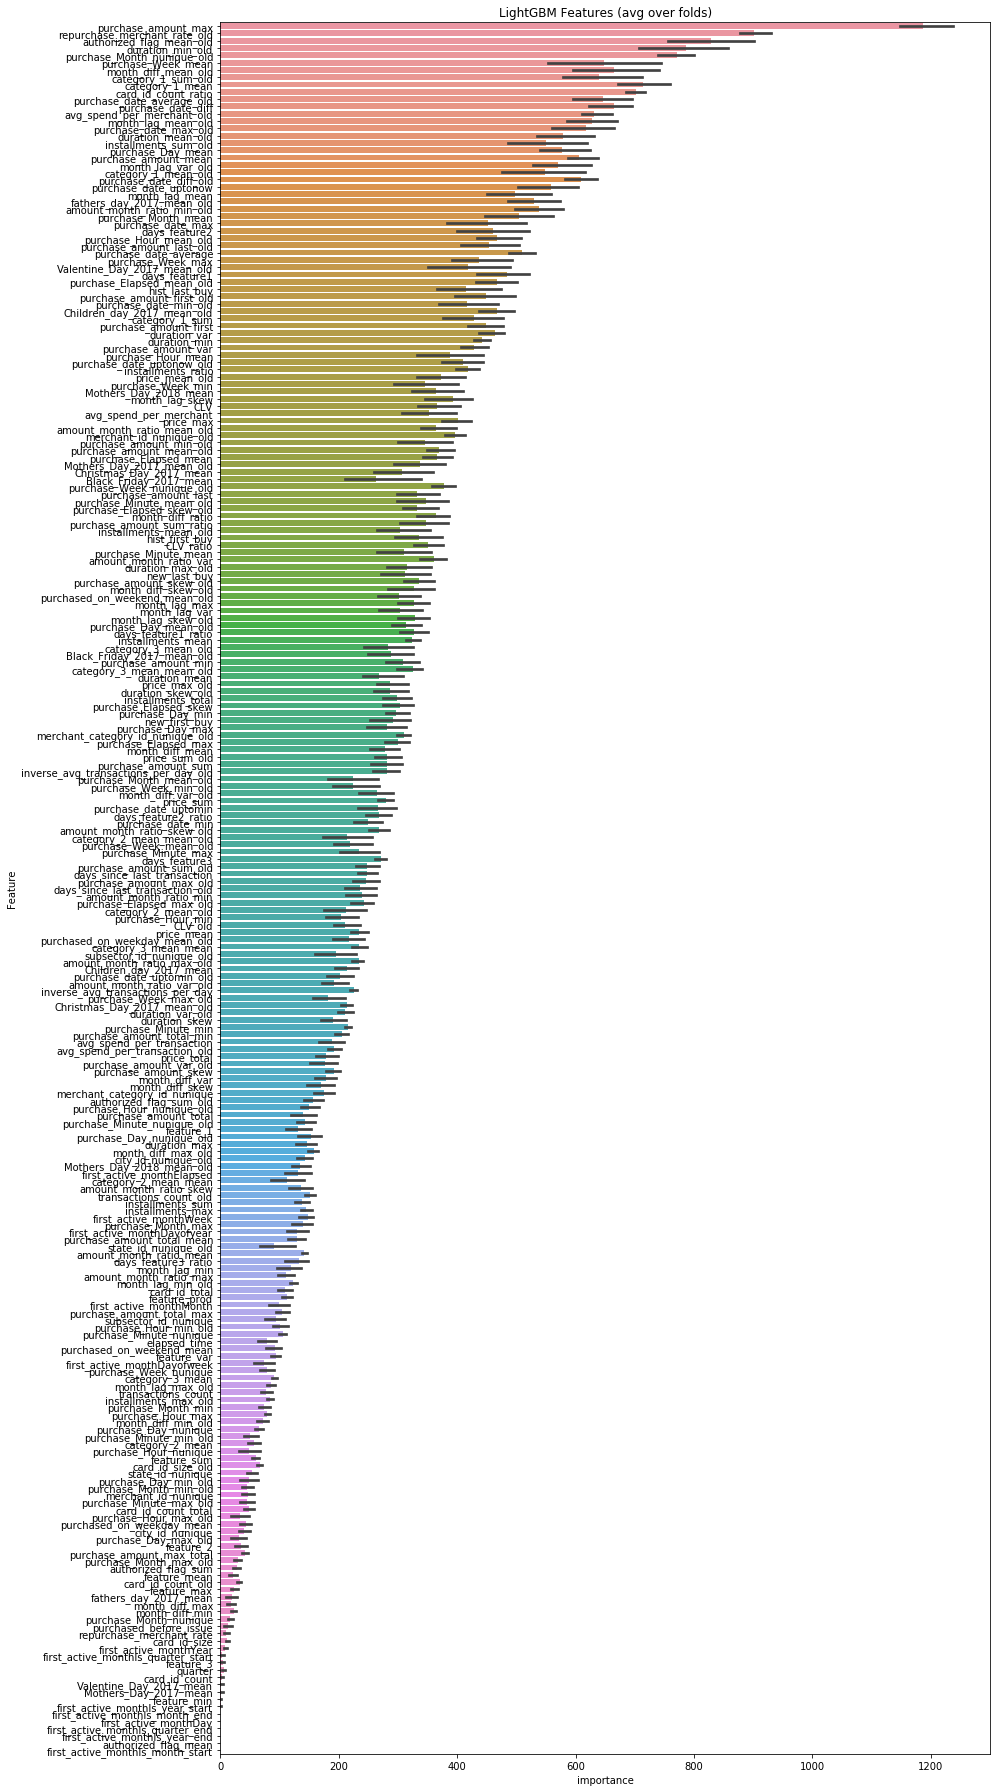

In [22]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [111]:
len(best_features.sort_values(by='importance', ascending=False)[:800]['Feature'].unique())

170

In [120]:
best_features.head(5)

,Feature,importance,fold
0,purchase_amount_max,1003,1
1,duration_min_old,779,1
2,authorized_flag_mean_old,865,1
3,purchase_Week_mean,608,1
4,month_diff_mean_old,637,1


In [106]:
picked_feats = best_features.sort_values(by='importance', ascending=False)[:800]['Feature'].unique()

In [23]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [24]:
import gc

In [31]:
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # params optimized by optuna
        params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)
                }

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)

    if not debug:
        # save submission file
        submission_name = pd.to_datetime("today")
        sub_df = pd.DataFrame({"card_id":test_df2["card_id"].values})
        sub_df["target"] = sub_preds
        sub_df.to_csv(f'submission-{submission_name}.csv', index=False)
#         test_df.loc[:,'target'] = sub_preds
#         test_df = test_df.reset_index()
#         test_df[['card_id', 'target']].to_csv(submission_name, index=False)

In [32]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

Starting LightGBM. Train shape: (201917, 244), test shape: (123623, 242)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65646	test's rmse: 3.73613
[200]	train's rmse: 3.57825	test's rmse: 3.69908
[300]	train's rmse: 3.53062	test's rmse: 3.68627
[400]	train's rmse: 3.49813	test's rmse: 3.68131
[500]	train's rmse: 3.47268	test's rmse: 3.67856
[600]	train's rmse: 3.45119	test's rmse: 3.67775
[700]	train's rmse: 3.43145	test's rmse: 3.67705
[800]	train's rmse: 3.41343	test's rmse: 3.67726
[900]	train's rmse: 3.39685	test's rmse: 3.67719
[1000]	train's rmse: 3.38086	test's rmse: 3.67686
[1100]	train's rmse: 3.36531	test's rmse: 3.67723
[1200]	train's rmse: 3.35107	test's rmse: 3.67753
Early stopping, best iteration is:
[1011]	train's rmse: 3.37903	test's rmse: 3.67683
Fold  1 RMSE : 3.676833
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65398	test's rmse: 3.78569
[200]	train's rmse: 3.57632	test's rmse: 3.75217
[30

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


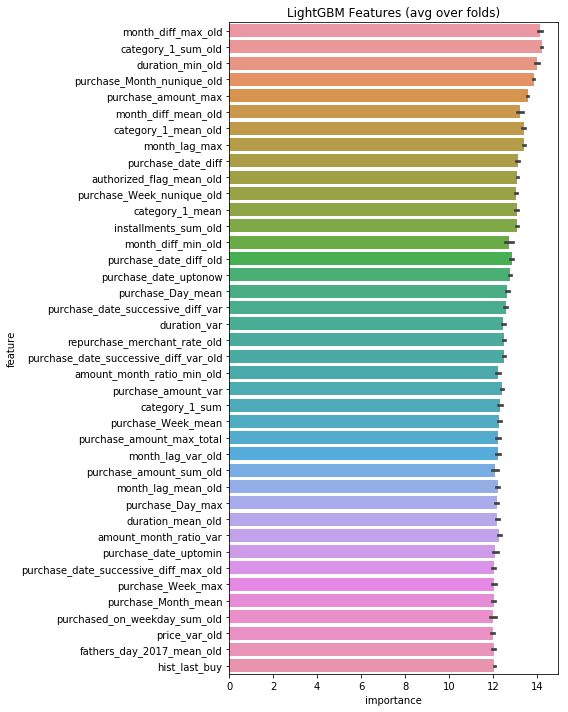

In [33]:
kfold_lightgbm(train_df2, test_df2, num_folds=11, stratified=False, debug=False)

In [23]:
submission_name = pd.to_datetime("today")

In [24]:
sub_df = pd.DataFrame({"card_id":test_df2["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv(f'submission-{submission_name}.csv', index=False)

In [25]:
!ls

'Blending submissions.ipynb'
'Elo - ML model - 3.695 beta.ipynb'
'Elo - ML model - 3.695.ipynb'
'Elo - ML model - 3.696.ipynb'
'Elo - ML model - beta.ipynb'
'Elo - ML model - cat aggregates.ipynb'
'Elo - ML model clean.ipynb'
'Elo - ML model proc_df.ipynb'
'Elo - ML model-RF copy.ipynb'
'Elo - ML model-backup.ipynb'
'Elo - ML model-new.ipynb'
'Elo RF- New.ipynb'
'Elo RF.ipynb'
'Elo end 2 end.ipynb'
'Elo feature engineering - 3.696.ipynb'
'Elo feature engineering 3.695 beta.ipynb'
'Elo feature engineering 3.695.ipynb'
'Elo feature engineering beta .ipynb'
'Elo feature engineering using agg.ipynb'
'Elo feature engineering-backup.ipynb'
'Elo feature engineering-proc_df - new-Copy1.ipynb'
'Elo feature engineering-proc_df - new.ipynb'
'Elo feature engineering-proc_df-OLD.ipynb'
'Elo feature engineering-proc_df.ipynb'
'Elo merchant category reco - using RF.ipynb'
'Elo outlier predictions & blending .ipynb'
'Feature selection using Boruta.ipynb'
'Null importances - beta.ipynb'
'Outlier classi

In [115]:
FileLink(f'submission-{submission_name}.csv')

/home/chandrasekhar/private/kaggle/submission-2019-02-10 18:01:58.093819.csv

### Blend

In [79]:
p1 = pd.read_csv(f'submission-{submission_name}.csv')
p2 = pd.read_csv('submission-2019-02-02 23:13:59.670630.csv')

In [80]:
p1.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.960024
1,C_ID_130fd0cbdd,-0.421305
2,C_ID_b709037bc5,-1.011111
3,C_ID_d27d835a9f,-0.141994
4,C_ID_2b5e3df5c2,-1.270823


In [81]:
p2.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.072875
1,C_ID_130fd0cbdd,-0.348145
2,C_ID_b709037bc5,-0.949767
3,C_ID_d27d835a9f,-0.149493
4,C_ID_2b5e3df5c2,-1.212316


In [83]:
p3 = p1.copy()

In [84]:
p3.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.960024
1,C_ID_130fd0cbdd,-0.421305
2,C_ID_b709037bc5,-1.011111
3,C_ID_d27d835a9f,-0.141994
4,C_ID_2b5e3df5c2,-1.270823


In [102]:
p3 = pd.DataFrame({"card_id":test_df2["card_id"].values})
p3["target"] = p1['target']*.5 + p2['target']*.5

In [103]:
p3.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.016449
1,C_ID_130fd0cbdd,-0.384725
2,C_ID_b709037bc5,-0.980439
3,C_ID_d27d835a9f,-0.145743
4,C_ID_2b5e3df5c2,-1.241569


In [104]:
p3.to_csv('blend_kfol_st.csv',index=False)

In [47]:
message = 'using blend kfold + stratified, purchase amount trimmed'

In [106]:
p3.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.016449
1,C_ID_130fd0cbdd,-0.384725
2,C_ID_b709037bc5,-0.980439
3,C_ID_d27d835a9f,-0.145743
4,C_ID_2b5e3df5c2,-1.241569


In [26]:
filename = f'submission-{submission_name}.csv'

In [27]:
filename

'submission-2019-02-12 22:57:39.862967.csv'

In [28]:
!kaggle competitions submit elo-merchant-category-recommendation -f 'submission-2019-02-12 22:57:39.862967.csv' -m 'removed some unwanted aggs'

100%|#######################################| 4.24M/4.24M [00:22<00:00, 201kB/s]
Successfully submitted to Elo Merchant Category Recommendation

In [36]:
train = train_df2.copy()
train['rounded_target'] = train['target'].round(0)
train = train.sort_values('rounded_target').reset_index(drop=True)
vc = train['rounded_target'].value_counts()
vc = dict(sorted(vc.items()))
df = pd.DataFrame()
train['indexcol'],i = 0,1
for k,v in vc.items():
    step = train.shape[0]/v
    indent = train.shape[0]/(v+1)
    df2 = train[train['rounded_target'] == k].sample(v, random_state=120).reset_index(drop=True)
    for j in range(0, v):
        df2.at[j, 'indexcol'] = indent + j*step + 0.000001*i
    df = pd.concat([df2,df])
    i+=1

In [37]:
train = df.sort_values('indexcol', ascending=True).reset_index(drop=True)

In [38]:
train.head().T

,0,1,2,3,4
first_active_month,2017-12-01 00:00:00,2016-12-01 00:00:00,2016-09-01 00:00:00,2017-11-01 00:00:00,2017-11-01 00:00:00
card_id,C_ID_176ecc65bd,C_ID_6082929d3a,C_ID_a87bbd85a7,C_ID_92e4809531,C_ID_d2dd6bbf9a
feature_1,0.0131446,0.0107116,0.0104794,0.00805849,0.0107116
feature_2,0.0113848,0.0113848,0.0113848,0.0113848,0.0113848
feature_3,0.0114275,0.0102828,0.0114275,0.0102828,0.0102828
target,-0.279039,-0.926039,0.475326,0.516026,-0.100927
first_active_monthYear,2017,2016,2016,2017,2017
first_active_monthMonth,12,12,9,11,11
first_active_monthWeek,48,48,35,44,44
first_active_monthDay,1,1,1,1,1
